(512, 512, 3)


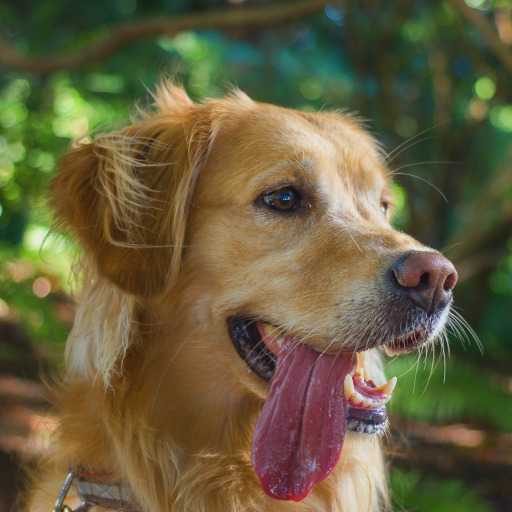

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from IPython.display import display

# Loading the image
img = Image.open('res/dog.png')
pixels = np.array(img)

print(pixels.shape)
display(img)

In [2]:
def process_img(img, pixels_op):
    pixels = np.copy(img)

    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            r, g, b = pixels[i, j]
            pixels[i, j] = pixels_op(r, g, b)

    return Image.fromarray(pixels)

## Histogram

In [3]:
def index_along_axis(arr, value, axis):
    for i in range(len(arr)):
        if arr[i][axis-1] == value:
            return i
    return -1

def count_occurences(arr, value):
    index = index_along_axis(arr, value, 1)
    if index != -1:
        level, count = arr[index]
        arr[index] = (level, count + 1)
    else:
        arr.append((value, 1))

def color_histogram(img):
    pixels = np.copy(img)
    histogram = { 'red': [], 'green': [], 'blue': [] }

    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            r, g, b = pixels[i, j]
            count_occurences(histogram['red']  , r)
            count_occurences(histogram['green'], g)
            count_occurences(histogram['blue'] , b)

    return histogram

def plot_histogram(histogram):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for color, ax in zip(histogram.keys(), axs):
        x, y = zip(*histogram[color])

        ax.hist(x, bins=len(x), weights=y, color=color, edgecolor='white')
        ax.set_title(f"{color.capitalize()} level hist")

    plt.show()

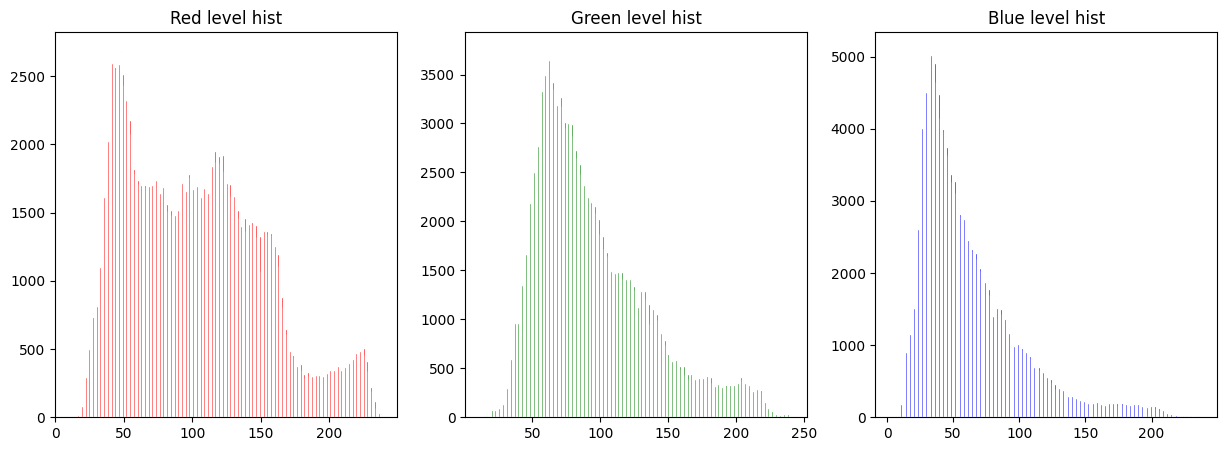

In [4]:
histogram = color_histogram(img)
plot_histogram(histogram)

## Filtering

In [5]:
def apply_filter(img, vec):
    def _filter(r, g, b):
        return (r * vec[0], g * vec[1], b * vec[2])

    return process_img(img, _filter)

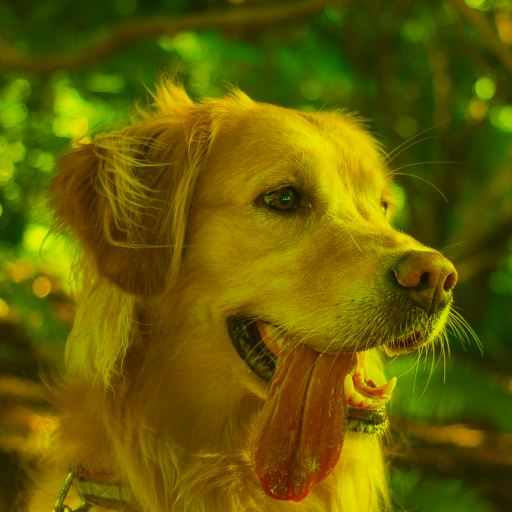

In [6]:
red_green_img = apply_filter(img=img, vec=(1, 1, 0))
display(red_green_img)

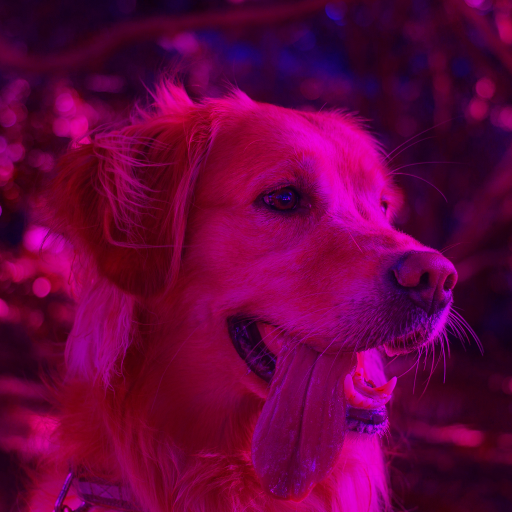

In [7]:
red_blue_img = apply_filter(img=img, vec=(1, 0, 1))
display(red_blue_img)

## Grayscale

In [8]:
def apply_grayscale(img, pleasing=False):
    def _grayscale(r, g, b):
        if pleasing:
            avg = int(0.2126 * r + 0.7152 * g + 0.0722 * b)
        else :
            avg = (int(r) + int(g) + int(b)) // 3

        return (avg)
    
    return process_img(img, _grayscale)

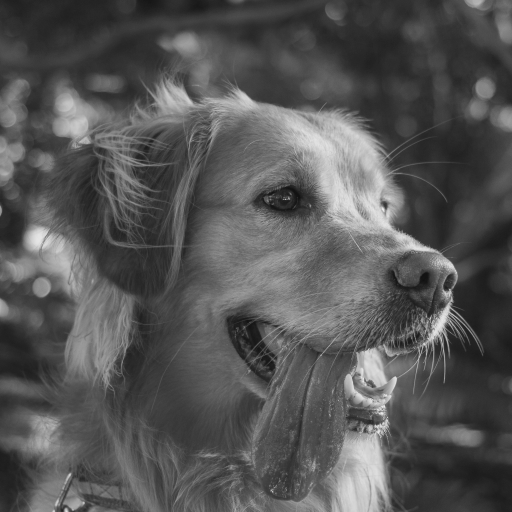

In [9]:
grayscale_img = apply_grayscale(img=img)
display(grayscale_img)

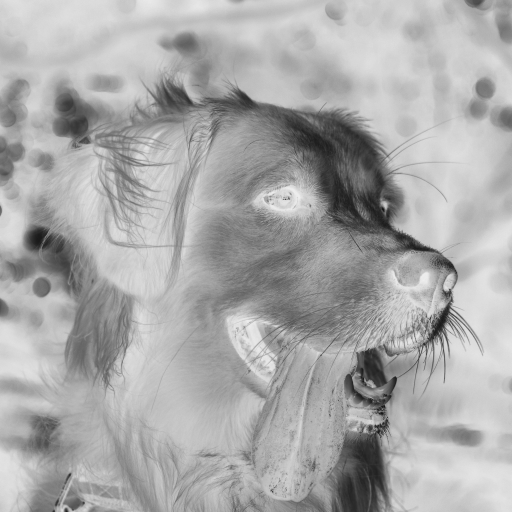

In [10]:
# Inversed grayscaled image
inv_contrast = lambda r, g, b: (255 - r, 255 - g, 255 - b)
inv_grayscale_img = process_img(img=grayscale_img, pixels_op=inv_contrast)
display(inv_grayscale_img)

## Downsample

In [11]:
def apply_downsample(img, samples):
    pixels = np.array(img)
    rows, cols = pixels.shape[0], pixels.shape[1]
    sampled_rows, sample_cols = int(rows / samples), int(cols / samples)
    
    img_builder = np.zeros((sampled_rows, sample_cols, 3), dtype=np.uint8)

    for i in range(sampled_rows):
        for j in range(sample_cols):
            img_builder[i, j] = pixels[i * samples, j * samples]

    return Image.fromarray(img_builder)

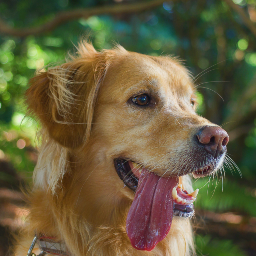

In [12]:
downsampled_img = apply_downsample(img=img, samples=2)
display(downsampled_img)

## Outlines Detection

In [13]:
from scipy.signal import convolve2d

def img_outlines(img):
    pixels = np.array(img.convert('L'))

    kernel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    kernel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    edges_x = np.abs(convolve2d(pixels, kernel_x, mode='same'))
    edges_y = np.abs(convolve2d(pixels, kernel_y, mode='same'))

    edges = np.sqrt(edges_x ** 2 + edges_y ** 2)
    edges = (edges / edges.max()) * 255
    edges = edges.astype(np.uint8)

    return Image.fromarray(edges)

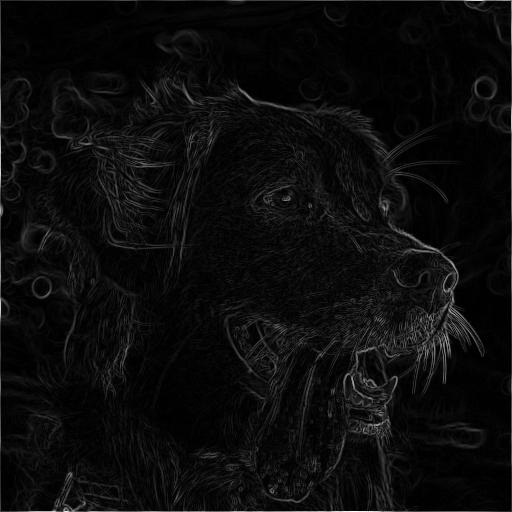

In [14]:
outlined = img_outlines(img)
display(outlined)

## Blur

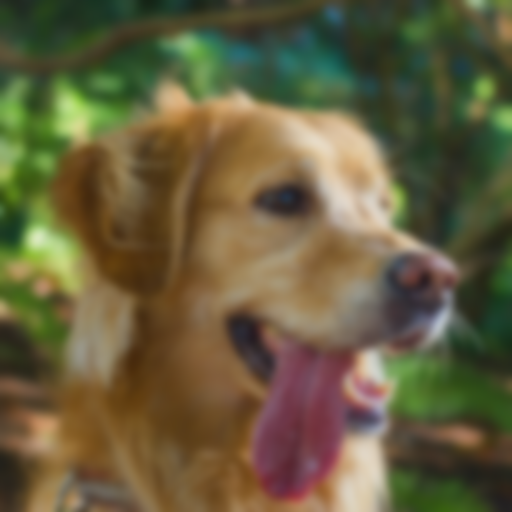

In [24]:
# Apply Gaussian blur
blurred_image = img.filter(ImageFilter.GaussianBlur(radius=4))
display(blurred_image)

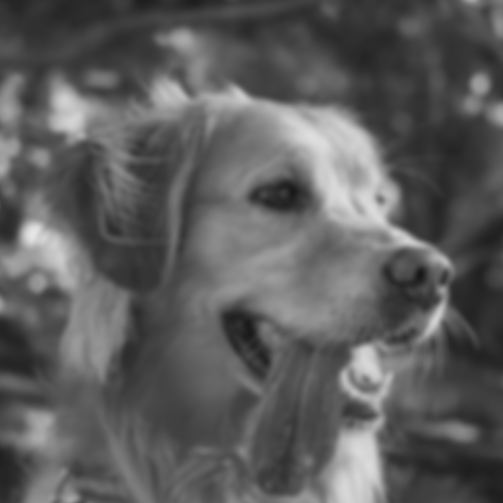

In [4]:
def convolve2d(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate output shape
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # Initialize output matrix
    output = np.zeros((output_height, output_width))

    # Perform convolution
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel)

    return output

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

def apply_gaussian_blur(image, kernel_size=3, sigma=1):
    kernel = gaussian_kernel(kernel_size, sigma)

    # Ensure image matrix is in float format for proper convolution
    image = image.astype(np.float64)

    # Apply convolution operation
    blurred_image = convolve2d(image, kernel)

    return Image.fromarray(blurred_image.astype(np.uint8))


blurred = apply_gaussian_blur(np.array(img.convert('L')), kernel_size=10, sigma=3)
display(blurred)

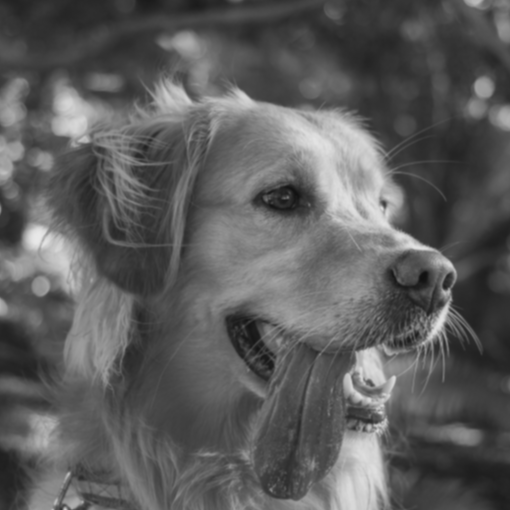

In [11]:
kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

pxls = np.array(img.convert('L')).astype(np.float64)
transformed = convolve2d(image=pxls, kernel=kernel)
display(Image.fromarray(transformed.astype(np.uint8)))